# **Hands-on: molecular data reading**

- Author: Tales Miguel Machado Pereira
- RA: 140247
- Professor: Dr. Marcos Quiles

### **1.Load and unpack the QM9 dataset**

[Data for 133885 GDB-9 molecules](https://springernature.figshare.com/articles/dataset/Data_for_6095_constitutional_isomers_of_C7H10O2/1057646?backTo=%2Fcollections%2FQuantum_chemistry_structures_and_properties_of_134_kilo_molecules%2F978904&file=3195389)

#### **1.1. About the Dataset**

"Molecular structures and properties are publicly available at Figshare (Data Citation 1) in a plain text XYZ-like format described below. Deposited files include the 133, 885 GDB-1 to GDB-9 molecules (dsgdb9nsd.xyz.tar.bz2), the 6,095 constitutional isomers of C7H10O2 (dsC7O2H10nsd.xyz.tar.bz2), the 100 validation molecules (see Table 1) enthalpies of atomization (validation.txt), and atomic reference data (atomref.txt)."

[Ramakrishnan, R., Dral, P., Rupp, M. et al. Quantum chemistry structures and properties of 134 kilo molecules. Sci Data 1, 140022 (2014).](https://www.nature.com/articles/sdata201422#Sec4)

#### **1.2. General structure of QM9 XYZ files**

- Line 1: Number of atoms in the molecule

- Line 2: Extended header with computed molecular properties (16 values):
    1. gdb ID - Database identifier
    2. A - Rotational constant A (GHz)
    3. B - Rotational constant B (GHz)
    4. C - Rotational constant C (GHz)
    5. μ - Dipole moment (Debye)
    6. α - Isotropic polarizability (Bohr³)
    7. εHOMO - Energy of Highest Occupied Molecular Orbital (Hartree)
    8. εLUMO - Energy of Lowest Unoccupied Molecular Orbital (Hartree)
    9. Δε - Gap between HOMO and LUMO (Hartree)
    10. 〈R²〉 - Electronic spatial extent (Bohr²)
    11. zpve - Zero point vibrational energy (Hartree)
    12. U₀ - Internal energy at 0K (Hartree)
    13. U - Internal energy at 298.15K (Hartree)
    14. H - Enthalpy at 298.15K (Hartree)
    15. G - Free energy at 298.15K (Hartree)
    16. Cv - Heat capacity at 298.15K (cal/mol·K)

- Lines 3 to N+2: Atomic coordinates and charges (5 columns):
    1. Element symbol - Chemical element (C, H, N, O, etc.)
    2. x coordinate - Position in Angstroms
    3. y coordinate - Position in Angstroms
    4. z coordinate - Position in Angstroms
    5. Partial charge - Mulliken partial charge (electrons)
    
- Line N+3: Harmonic vibrational frequencies (cm⁻¹) - varies by molecule size

- Line N+4: Mulliken charges by atom type

- Lines N+5 & N+6: InChI strings for chemical identification and verification

In [1]:
import tarfile

def unpack_database(db_path='db/dsgdb9nsd.xyz.tar.bz2', dest_path='db/qm9_unpacked'):
    """
    Unpack 
    """
    # Unpack the tar.bz2 file
    with tarfile.open(db_path, 'r:bz2') as tar:
        tar.extractall(path=dest_path)

    print(f"\nDatabase unpacked to {dest_path}")


# Path to the tar.bz2 file inside the db folder
db_path = 'db/dsgdb9nsd.xyz.tar.bz2'
dest_path = 'db/qm9_unpacked'
unpack_database(db_path, dest_path)

/tmp/ipykernel_20130/3539781899.py:9: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar.extractall(path=dest_path)



Database unpacked to db/qm9_unpacked


### **2.XYZ File Parser**

In [2]:
import os
import glob
import pandas as pd
from rdkit import Chem # SMILES validation
import warnings
warnings.filterwarnings('ignore')

In [3]:
def parse_xyz_file(file_path):
    """Parse QM9 XYZ file and extract molecular properties and SMILES."""
    with open(file_path, 'r') as f:
        lines = [line.strip() for line in f.readlines()]
    
    n_atoms = int(lines[0])

    # header_parts = lines[1].split('\t')
    
    # SMILES is located at the penultimate line
    smiles = lines[-2].split('\t')[0]  # duplicated SMILES entries for some reason, taking the first one
    
    # Extract all 16 molecular properties from the header line
    properties = [
        'gdb_id', 'rot_const_A', 'rot_const_B', 'rot_const_C', 'dipole_moment',
        'isotropic_polarizability', 'homo_energy', 'lumo_energy', 'homo_lumo_gap',
        'electronic_spatial_extent', 'zpve', 'U0', 'U', 'H', 'G', 'Cv'
    ]

    header_values = lines[1].split()
    # If the first value is not a digit, skip it (e.g., 'gdb')
    if not header_values[0].isdigit():
        header_values = header_values[1:]

    # Mapping property names to their values
    data = {name: int(val) if name == 'gdb_id' else float(val) 
            for name, val in zip(properties, header_values)}
    
    data['n_atoms'] = n_atoms
    data['smiles'] = smiles
    return data

In [4]:
def validate_and_canonicalize_smiles(smiles):
    """Validate SMILES and generate canonical version."""
    # Validate original SMILES
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None, False
    
    # Generate canonical SMILES
    canonical_smiles = Chem.MolToSmiles(mol, canonical=True)
    
    return canonical_smiles, True

In [5]:
def process_xyz_files(directory_path, max_files=None):
    """Process XYZ files and extract SMILES and properties."""
    xyz_files = sorted(glob.glob(os.path.join(directory_path, "*.xyz")))
    
    if max_files:
        xyz_files = xyz_files[:max_files]
    
    results = []
    
    for file_path in xyz_files:
        # Parse XYZ file (SMILES already included)
        data = parse_xyz_file(file_path)
        
        # Validate and canonicalize SMILES
        canonical_smiles, is_valid = validate_and_canonicalize_smiles(data['smiles'])
        
        # Only keep valid molecules
        if is_valid:
            data['canonical_smiles'] = canonical_smiles
            results.append(data)
    
    return pd.DataFrame(results)

In [6]:
df = process_xyz_files('db/qm9_unpacked')
df.to_csv('qm9_complete_dataset.csv', index=False)
print(f"Processed {len(df)} molecules")

Processed 133885 molecules


### **3. Data Visualization**

Visualizing the distribution of all molecular properties in the dataset using Histograms.

#### **3.1. Properties**

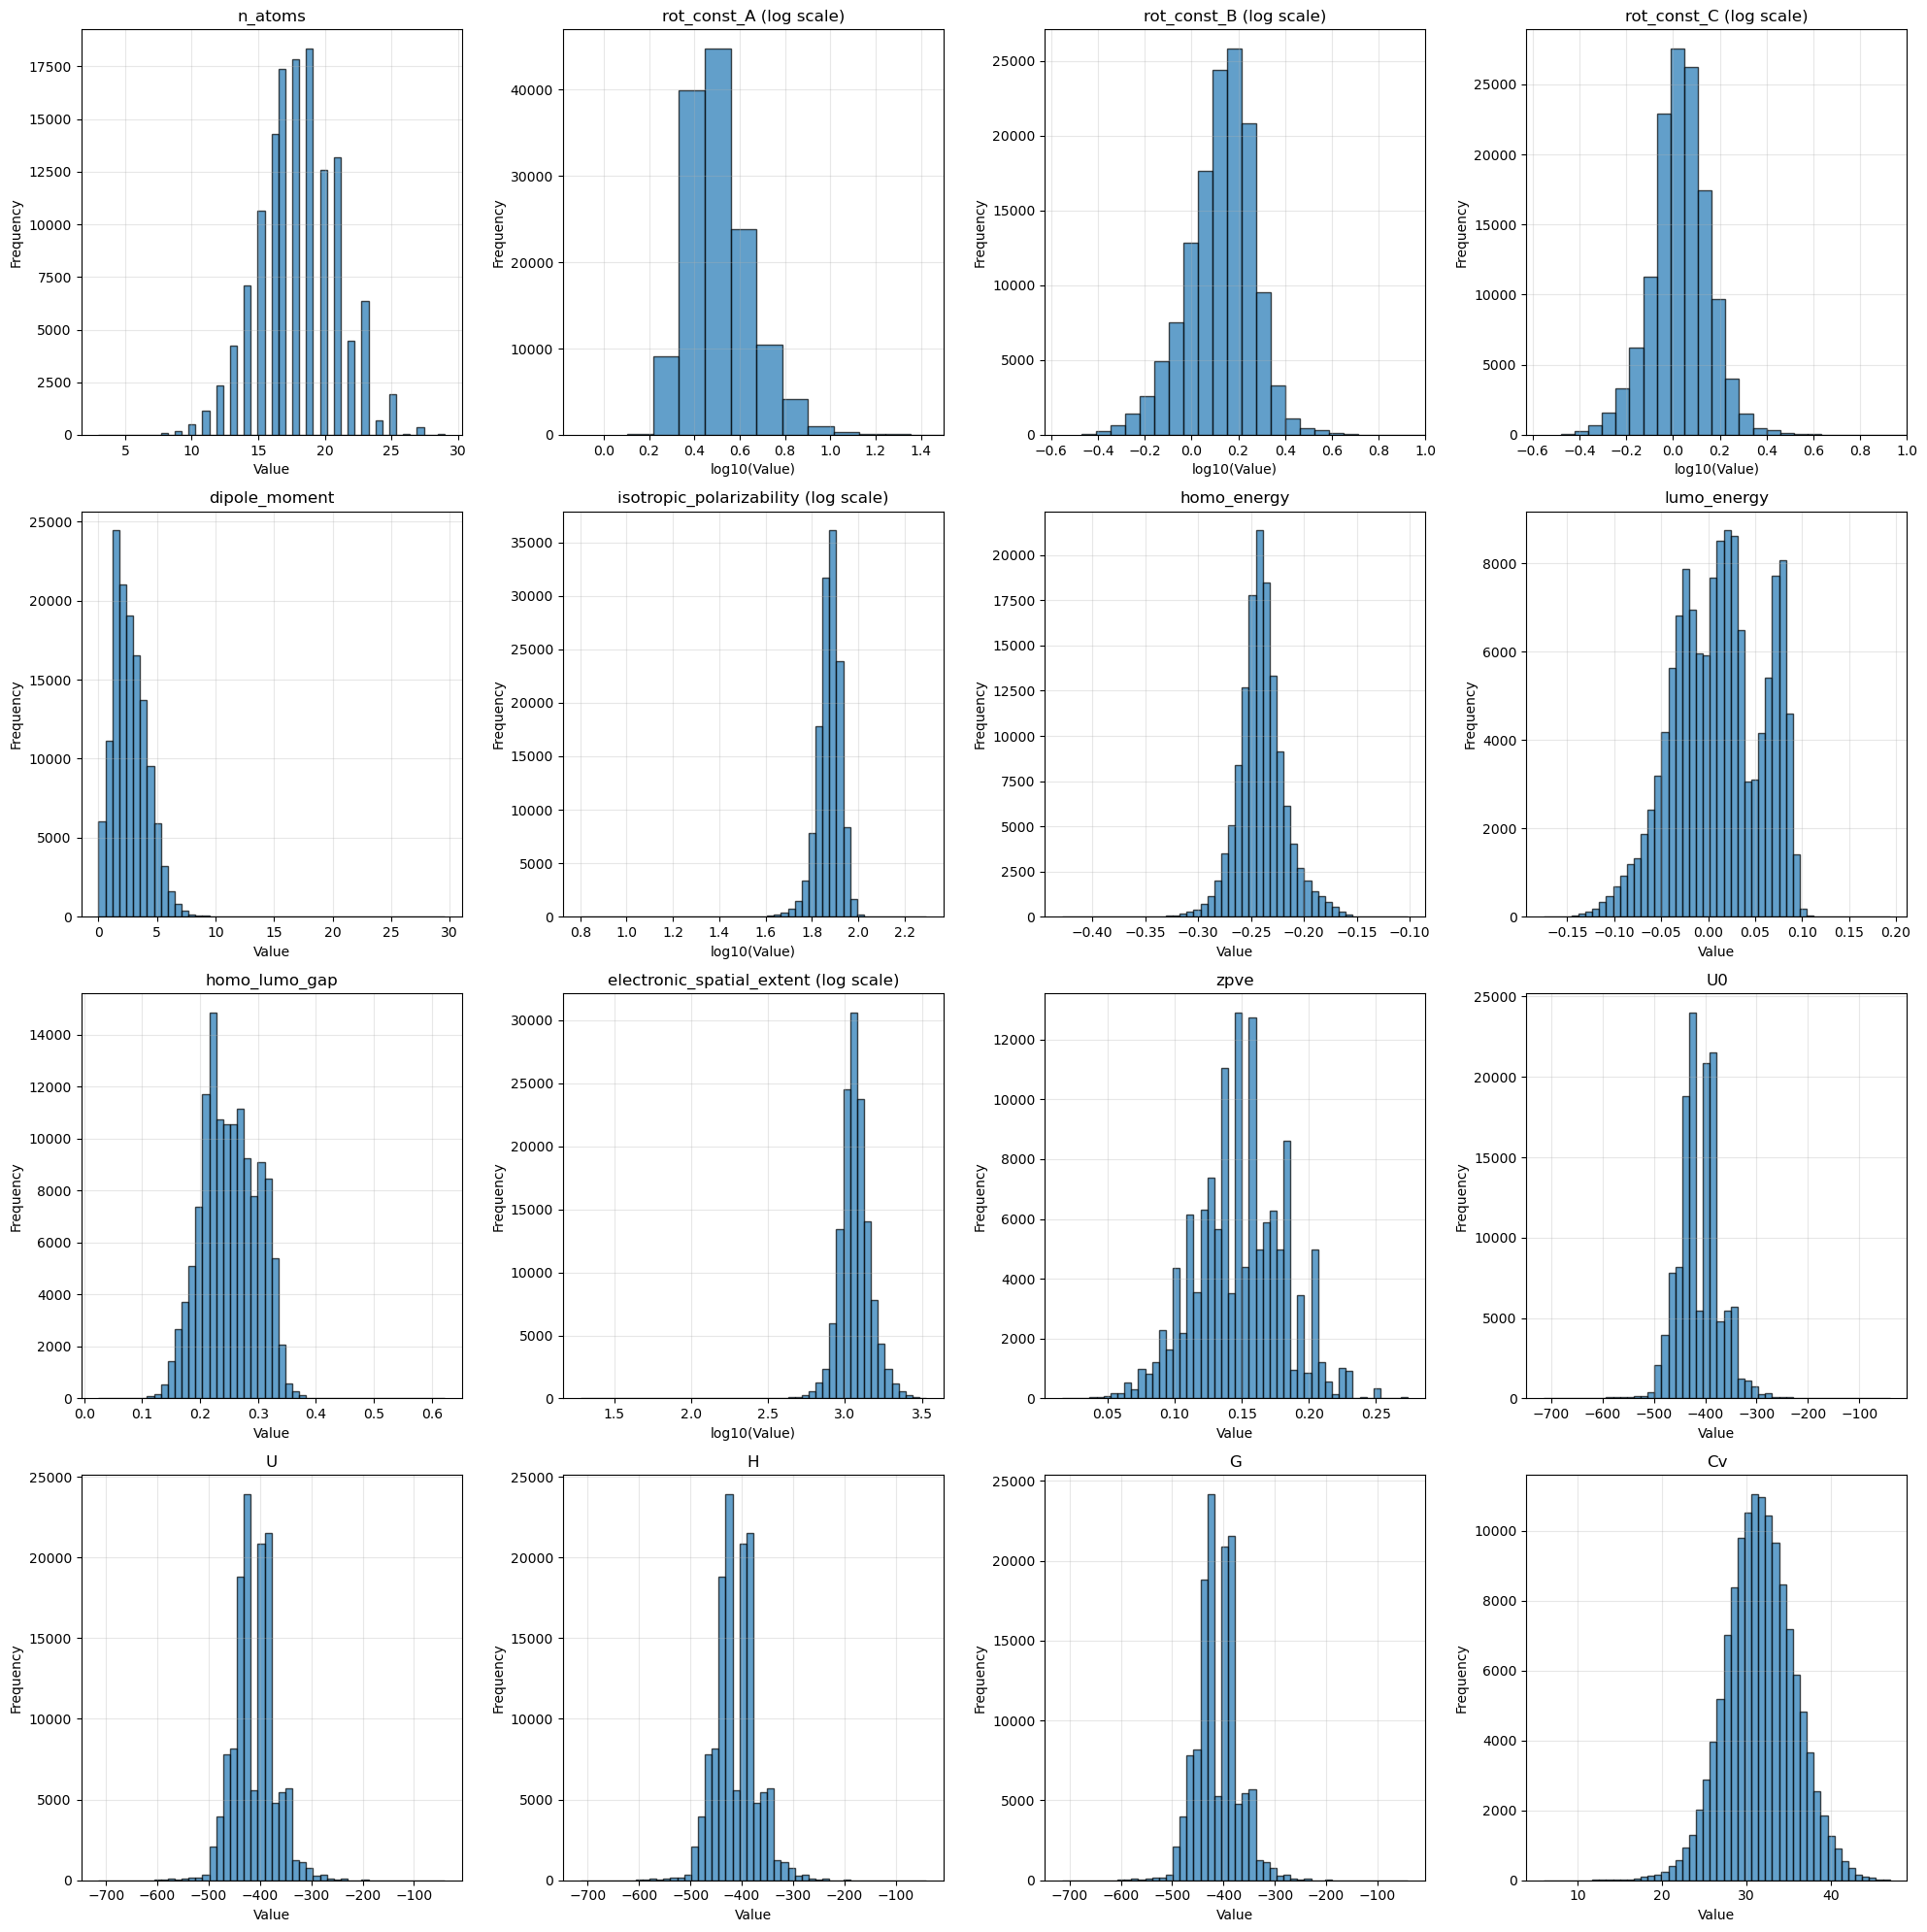


Summary Statistics:
n_atoms:
  Mean: 17.9837
  Std deviation:  2.9543
  Min:  3.0000
  Max:  29.0000

rot_const_A:
  Mean: 9.8144
  Std deviation:  1809.4657
  Min:  0.0000
  Max:  619867.6831
  Geometric Mean: 3.2254
  Zeros: 9 molecules

rot_const_B:
  Mean: 1.4061
  Std deviation:  1.5838
  Min:  0.3371
  Max:  437.9039
  Geometric Mean: 1.3269
  Zeros: 0 molecules

rot_const_C:
  Mean: 1.1249
  Std deviation:  1.0956
  Min:  0.3312
  Max:  282.9454
  Geometric Mean: 1.0750
  Zeros: 0 molecules

dipole_moment:
  Mean: 2.7060
  Std deviation:  1.5304
  Min:  0.0000
  Max:  29.5564

isotropic_polarizability:
  Mean: 75.1913
  Std deviation:  8.1878
  Min:  6.3100
  Max:  196.6200
  Geometric Mean: 74.7184
  Zeros: 0 molecules

homo_energy:
  Mean: -0.2400
  Std deviation:  0.0221
  Min:  -0.4286
  Max:  -0.1017

lumo_energy:
  Mean: 0.0111
  Std deviation:  0.0469
  Min:  -0.1750
  Max:  0.1935

homo_lumo_gap:
  Mean: 0.2511
  Std deviation:  0.0475
  Min:  0.0246
  Max:  0.6221

ele

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# Properties to plot (excluding gdb_id and smiles/canonical_smiles)
numeric_properties = [
    'n_atoms', 'rot_const_A', 'rot_const_B', 'rot_const_C', 
    'dipole_moment', 'isotropic_polarizability', 'homo_energy', 'lumo_energy', 
    'homo_lumo_gap', 'electronic_spatial_extent', 'zpve', 'U0', 'U', 'H', 'G', 'Cv'
]

# Properties that benefit from log scale (wide ranges, many zeros)
log_scale_properties = ['rot_const_A', 'rot_const_B', 'rot_const_C', 'isotropic_polarizability', 'electronic_spatial_extent']

# X-axis limits for specific properties (in log scale)
xlim_dict = {
    'rot_const_A': (None, 1.5),    # limit to log10 = 1.5 (31.62 GHz)
    'rot_const_B': (None, 1),    # limit to log10 = 1 (10 GHz)
    'rot_const_C': (None, 1)     # limit to log10 = 1 (10 GHz)
}

n_properties = len(numeric_properties)
n_cols = 4
n_rows = (n_properties + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5 * n_rows))
axes = axes.flatten()

# Plot histogram for each property
for i, prop in enumerate(numeric_properties):
    if prop in df.columns:
        data = df[prop]
        
        # plotting log scales
        if prop in log_scale_properties:
            # Filter out zeros and negative values for log scale
            data_filtered = data[data > 0]
            if len(data_filtered) > 0:
                axes[i].hist(np.log10(data_filtered), bins=50, alpha=0.7, edgecolor='black')
                axes[i].set_xlabel('log10(Value)')
                axes[i].set_title(f'{prop} (log scale)')
                
                # Set x-axis limits if specified
                if prop in xlim_dict:
                    axes[i].set_xlim(xlim_dict[prop])
            else:
                axes[i].hist(data, bins=50, alpha=0.7, edgecolor='black')
                axes[i].set_xlabel('Value')
                axes[i].set_title(f'{prop}')
        else:
            axes[i].hist(data, bins=50, alpha=0.7, edgecolor='black')
            axes[i].set_xlabel('Value')
            axes[i].set_title(f'{prop}')
        
        axes[i].set_ylabel('Frequency')
        axes[i].grid(True, alpha=0.3)
    else:
        axes[i].text(0.5, 0.5, f'{prop}\nNot available', 
                    transform=axes[i].transAxes, ha='center', va='center')
        axes[i].set_title(f'{prop} (Missing)')

for i in range(n_properties, len(axes)):
    axes[i].set_visible(False) # Unused subplots

plt.tight_layout()
plt.show()

# Print summary statistics
print("\nSummary Statistics:")
print("=" * 50)
for prop in numeric_properties:
    if prop in df.columns:
        data = df[prop]
        print(f"{prop}:")
        print(f"  Mean: {data.mean():.4f}")
        print(f"  Std deviation:  {data.std():.4f}")
        print(f"  Min:  {data.min():.4f}")
        print(f"  Max:  {data.max():.4f}")
        
        # Show additional stats for log-scale properties
        if prop in log_scale_properties:
            data_positive = data[data > 0]
            if len(data_positive) > 0:
                print(f"  Geometric Mean: {np.exp(np.log(data_positive).mean()):.4f}")
                print(f"  Zeros: {len(data) - len(data_positive)} molecules")
        print()

#### **3.2. Molecular composition and size**

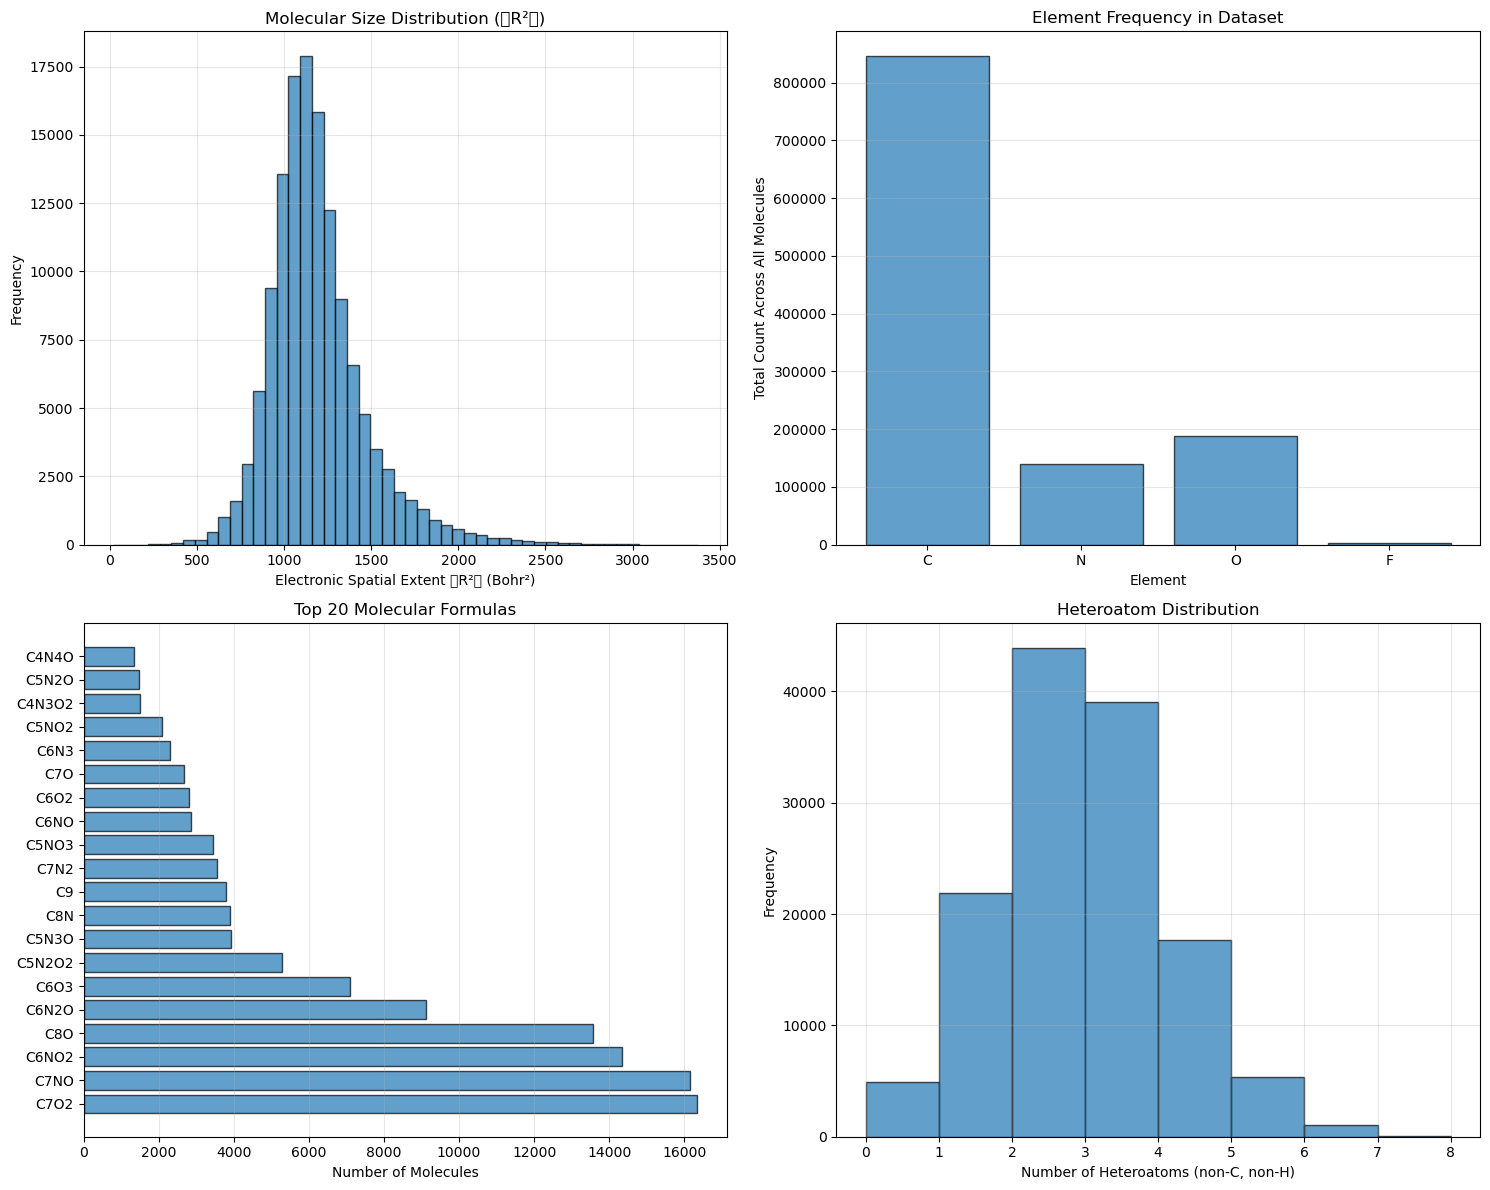


Composition and Size Statistics:
Molecular size (electronic spatial extent 〈R²〉):
  Mean: 1189.5274 Bohr²
  Std Deviation:  279.7572 Bohr²
  Min:  19.0002 Bohr²
  Max:  3374.7532 Bohr²

Atom count (for reference):
  Mean: 17.9837
  Std Deviation:  2.9543
  Min:  3.0000
  Max:  29.0000

Element diversity:
  Total unique elements: 4
  Elements present: C, F, N, O
  C: 846,556 atoms (71.9%)
  O: 187,997 atoms (16.0%)
  N: 139,764 atoms (11.9%)
  F: 3,314 atoms (0.3%)

Molecular formulas:
  Total unique formulas: 212
  Most common formula: C7O2 (16325 molecules)

Heteroatoms:
  Mean: 2.4728
  Std deviation:  1.1847
  Min:  0.0000
  Max:  7.0000
  Molecules with no heteroatoms: 4907
  Molecules with 1+ heteroatoms: 128978


In [8]:
from collections import Counter

fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Plot 1: Electronic spatial extent distribution (proper molecular size)
axes[0, 0].hist(df['electronic_spatial_extent'], bins=50, alpha=0.7, edgecolor='black')
axes[0, 0].set_xlabel('Electronic Spatial Extent 〈R²〉 (Bohr²)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Molecular Size Distribution (〈R²〉)')
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Element frequency
element_counts = Counter()
for smiles in df['canonical_smiles']:
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        for atom in mol.GetAtoms():
            element_counts[atom.GetSymbol()] += 1

elements = list(element_counts.keys())
counts = list(element_counts.values())
axes[0, 1].bar(elements, counts, alpha=0.7, edgecolor='black')
axes[0, 1].set_xlabel('Element')
axes[0, 1].set_ylabel('Total Count Across All Molecules')
axes[0, 1].set_title('Element Frequency in Dataset')
axes[0, 1].grid(True, alpha=0.3, axis='y')

# Plot 3: Top 20 molecular formulas
formula_counts = Counter()
for smiles in df['canonical_smiles']:
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        formula = {}
        for atom in mol.GetAtoms():
            symbol = atom.GetSymbol()
            formula[symbol] = formula.get(symbol, 0) + 1
        
        formula_str = ''.join([f"{elem}{count}" if count > 1 else elem 
                              for elem, count in sorted(formula.items())])
        formula_counts[formula_str] += 1

top_formulas = formula_counts.most_common(20)
formulas, counts = zip(*top_formulas)
axes[1, 0].barh(range(len(formulas)), counts, alpha=0.7, edgecolor='black')
axes[1, 0].set_yticks(range(len(formulas)))
axes[1, 0].set_yticklabels(formulas)
axes[1, 0].set_xlabel('Number of Molecules')
axes[1, 0].set_title('Top 20 Molecular Formulas')
axes[1, 0].grid(True, alpha=0.3, axis='x')

# Plot 4: Heteroatom distribution
heteroatom_counts = []
for smiles in df['canonical_smiles']:
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        heteroatoms = sum(1 for atom in mol.GetAtoms() 
                         if atom.GetSymbol() not in ['C', 'H'])
        heteroatom_counts.append(heteroatoms)

axes[1, 1].hist(heteroatom_counts, bins=range(0, max(heteroatom_counts) + 2), 
                alpha=0.7, edgecolor='black')
axes[1, 1].set_xlabel('Number of Heteroatoms (non-C, non-H)')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_title('Heteroatom Distribution')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print summary statistics
print("\nComposition and Size Statistics:")
print("=" * 50)

print("Molecular size (electronic spatial extent 〈R²〉):")
print(f"  Mean: {df['electronic_spatial_extent'].mean():.4f} Bohr²")
print(f"  Std Deviation:  {df['electronic_spatial_extent'].std():.4f} Bohr²")
print(f"  Min:  {df['electronic_spatial_extent'].min():.4f} Bohr²")
print(f"  Max:  {df['electronic_spatial_extent'].max():.4f} Bohr²")
print()

print("Atom count (for reference):")
print(f"  Mean: {df['n_atoms'].mean():.4f}")
print(f"  Std Deviation:  {df['n_atoms'].std():.4f}")
print(f"  Min:  {df['n_atoms'].min():.4f}")
print(f"  Max:  {df['n_atoms'].max():.4f}")
print()

print("Element diversity:")
print(f"  Total unique elements: {len(elements)}")
print(f"  Elements present: {', '.join(sorted(elements))}")
for elem, count in element_counts.most_common():
    percentage = (count / sum(element_counts.values())) * 100
    print(f"  {elem}: {count:,} atoms ({percentage:.1f}%)")
print()

print("Molecular formulas:")
print(f"  Total unique formulas: {len(formula_counts)}")
print(f"  Most common formula: {top_formulas[0][0]} ({top_formulas[0][1]} molecules)")
print()

print("Heteroatoms:")
print(f"  Mean: {np.mean(heteroatom_counts):.4f}")
print(f"  Std deviation:  {np.std(heteroatom_counts):.4f}")
print(f"  Min:  {min(heteroatom_counts):.4f}")
print(f"  Max:  {max(heteroatom_counts):.4f}")
print(f"  Molecules with no heteroatoms: {heteroatom_counts.count(0)}")
print(f"  Molecules with 1+ heteroatoms: {len(heteroatom_counts) - heteroatom_counts.count(0)}")

#### 3.3. Correlation Analysis

This correlation analysis considers:
- Every property;
- Number of atoms;
- Molecular weight.

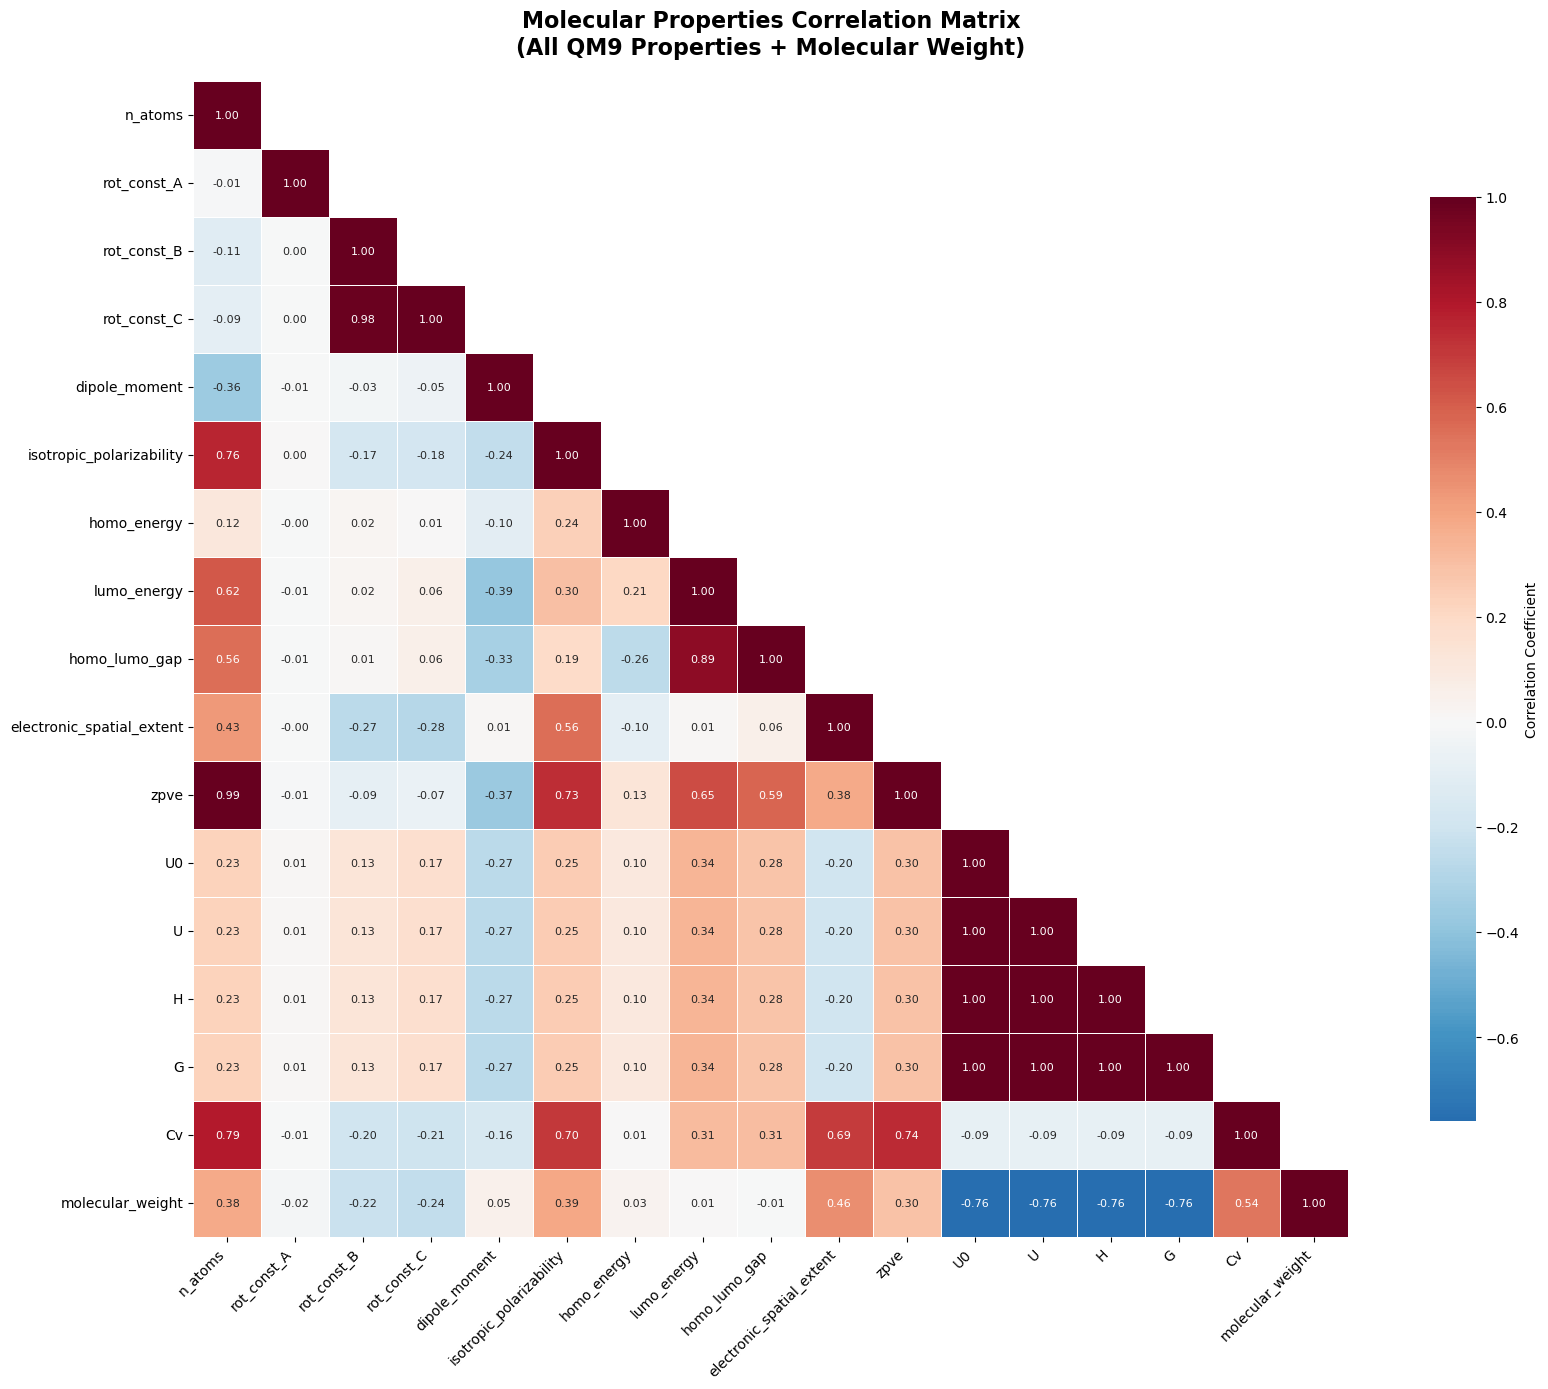

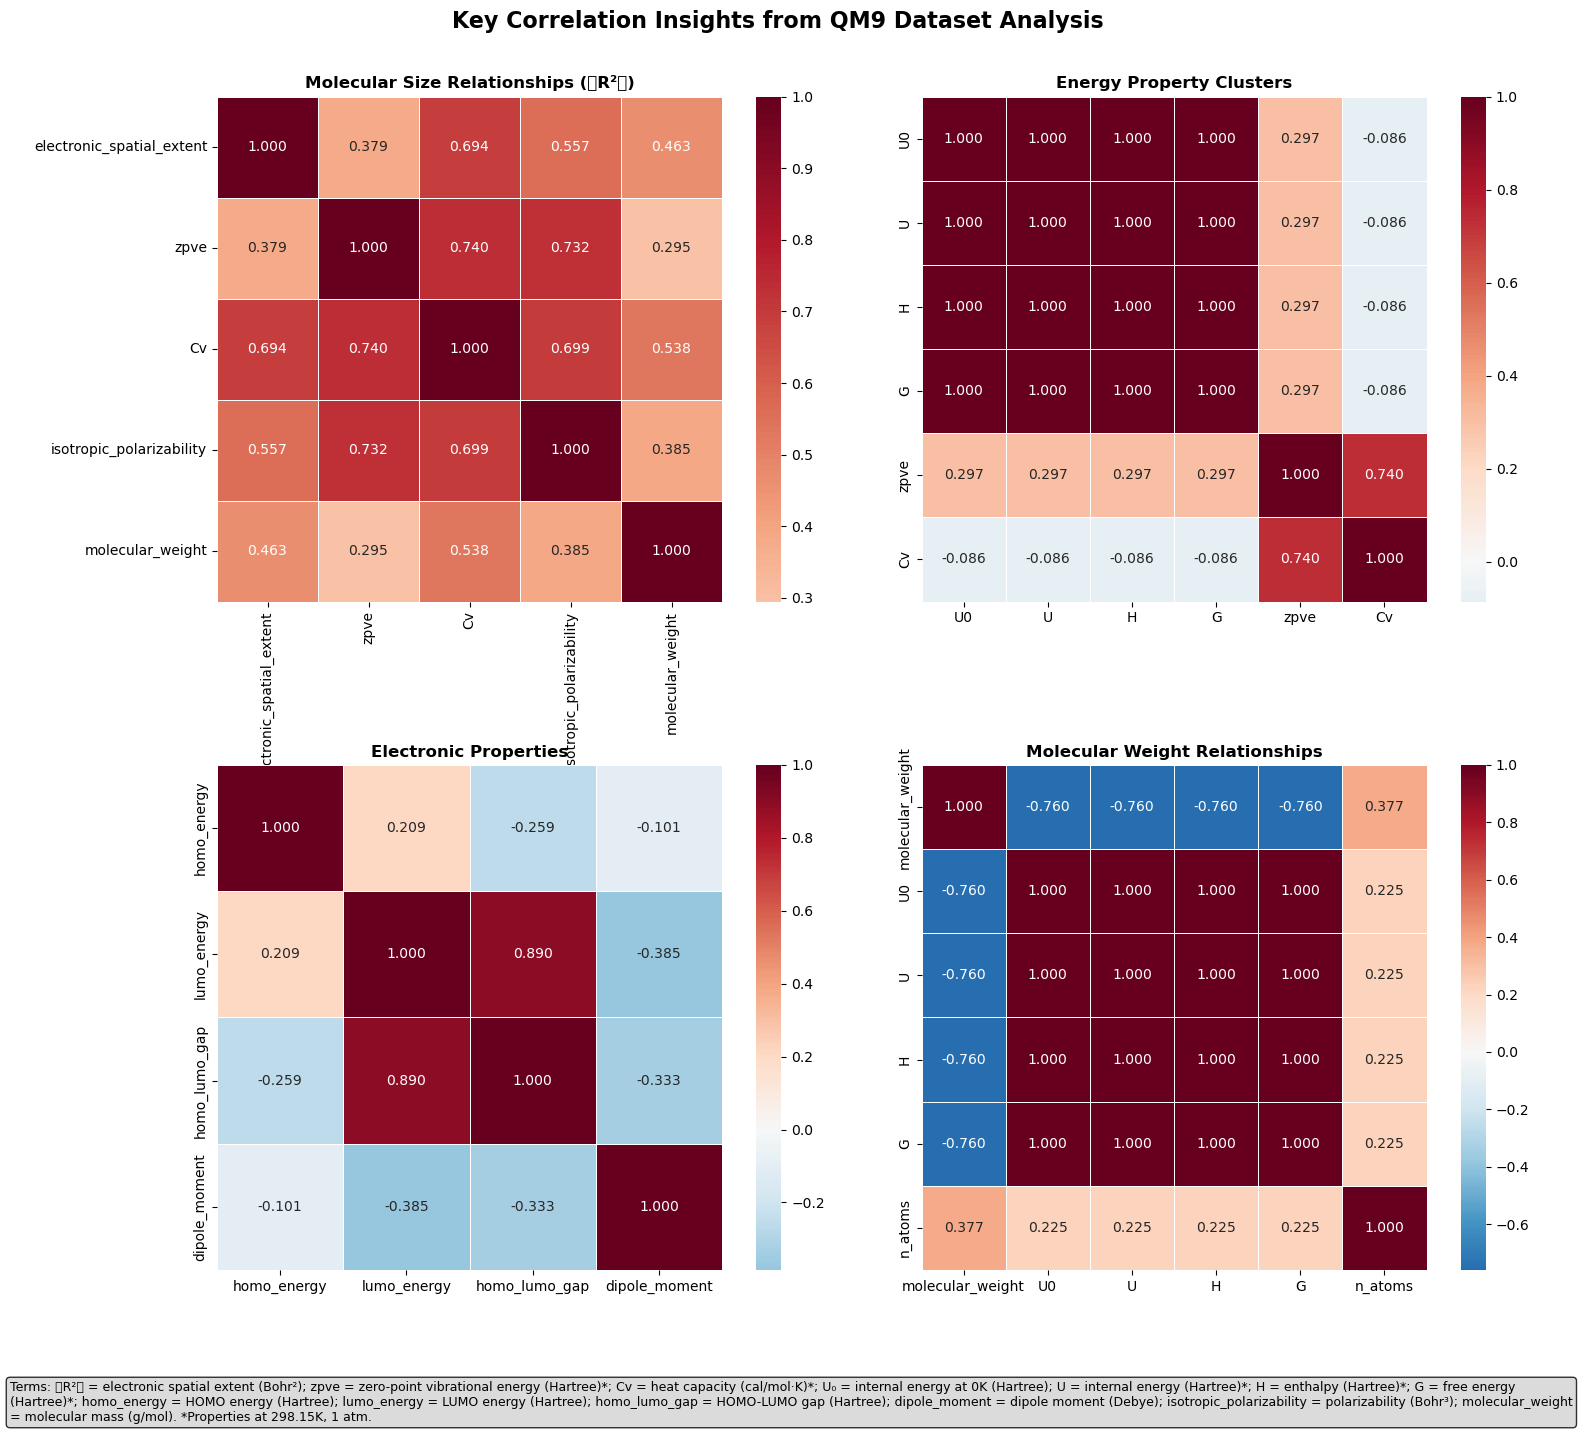

In [9]:
import seaborn as sns
from rdkit.Chem import Descriptors

# Calculating molecular weight for each molecule
molecular_weights = []
for smiles in df['canonical_smiles']:
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        molecular_weights.append(Descriptors.MolWt(mol))
    else:
        molecular_weights.append(np.nan)

df_corr = df.copy()
df_corr['molecular_weight'] = molecular_weights

correlation_properties = numeric_properties + ['molecular_weight']

# correlation matrix using df.corr()
correlation_data = df_corr[correlation_properties].dropna()
correlation_matrix = correlation_data.corr()

# Correlation heatmap
plt.figure(figsize=(18, 14))
# mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
mask = np.triu(correlation_matrix, k=1)

sns.heatmap(correlation_matrix, 
            mask=mask,
            annot=True, 
            cmap='RdBu_r', 
            center=0,
            square=True, 
            linewidths=0.5, 
            cbar_kws={"shrink": 0.8, "label": "Correlation Coefficient"},
            fmt='.2f', 
            annot_kws={'size': 8})

plt.title('Molecular Properties Correlation Matrix\n(All QM9 Properties + Molecular Weight)', 
          fontsize=16, fontweight='bold', pad=20)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(rotation=0, fontsize=10)
plt.tight_layout()
plt.show()

###### 2nd heatmap with focused insights ######

# Additional focused visualization for key insights
fig, axes = plt.subplots(2, 2, figsize=(16, 14))

# Plot 1: Size-related relationships (strongest correlations with electronic spatial extent)
size_props = ['electronic_spatial_extent', 'zpve', 'Cv', 'isotropic_polarizability', 'molecular_weight']
size_matrix = correlation_matrix.loc[size_props, size_props]
sns.heatmap(size_matrix, annot=True, cmap='RdBu_r', center=0, square=True,
            linewidths=0.5, fmt='.3f', annot_kws={'size': 10}, ax=axes[0, 0])
axes[0, 0].set_title('Molecular Size Relationships (〈R²〉)', fontweight='bold', fontsize=12)

# Plot 2: Energy cluster relationships
energy_props = ['U0', 'U', 'H', 'G', 'zpve', 'Cv']
energy_matrix = correlation_matrix.loc[energy_props, energy_props]
sns.heatmap(energy_matrix, annot=True, cmap='RdBu_r', center=0, square=True,
            linewidths=0.5, fmt='.3f', annot_kws={'size': 10}, ax=axes[0, 1])
axes[0, 1].set_title('Energy Property Clusters', fontweight='bold', fontsize=12)

# Plot 3: Electronic properties
electronic_props_full = ['homo_energy', 'lumo_energy', 'homo_lumo_gap', 'dipole_moment']
electronic_matrix = correlation_matrix.loc[electronic_props_full, electronic_props_full]
sns.heatmap(electronic_matrix, annot=True, cmap='RdBu_r', center=0, square=True,
            linewidths=0.5, fmt='.3f', annot_kws={'size': 10}, ax=axes[1, 0])
axes[1, 0].set_title('Electronic Properties', fontweight='bold', fontsize=12)

# Plot 4: Molecular weight vs other properties (showing negative correlations)
mw_props = ['molecular_weight', 'U0', 'U', 'H', 'G', 'n_atoms']
mw_matrix = correlation_matrix.loc[mw_props, mw_props]
sns.heatmap(mw_matrix, annot=True, cmap='RdBu_r', center=0, square=True,
            linewidths=0.5, fmt='.3f', annot_kws={'size': 10}, ax=axes[1, 1])
axes[1, 1].set_title('Molecular Weight Relationships', fontweight='bold', fontsize=12)

plt.suptitle('Key Correlation Insights from QM9 Dataset Analysis', 
             fontsize=16, fontweight='bold', y=1.02)

# Add term definitions as text box at the bottom
fig.text(0.02, 0.01, 
         'Terms: 〈R²〉 = electronic spatial extent (Bohr²); zpve = zero-point vibrational energy (Hartree)*; Cv = heat capacity (cal/mol·K)*; U₀ = internal energy at 0K (Hartree); '
         'U = internal energy (Hartree)*; H = enthalpy (Hartree)*; G = free energy (Hartree)*; homo_energy = HOMO energy (Hartree); '
         'lumo_energy = LUMO energy (Hartree); homo_lumo_gap = HOMO-LUMO gap (Hartree); dipole_moment = dipole moment (Debye); '
         'isotropic_polarizability = polarizability (Bohr³); molecular_weight = molecular mass (g/mol). *Properties at 298.15K, 1 atm.',
         fontsize=9, ha='left', va='bottom', wrap=True, 
         bbox=dict(boxstyle='round,pad=0.3', facecolor='lightgray', alpha=0.8))

plt.tight_layout()
plt.subplots_adjust(bottom=0.12)  # caption footer
plt.show()

In [10]:
# Statistical analysis of correlations
print("\nCorrelation Analysis Summary:")
print("=" * 70)

# Strongest positive correlations
print("Strongest Positive Correlations (r > 0.9):")
strong_pos = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        corr_val = correlation_matrix.iloc[i, j]
        if corr_val > 0.9:
            prop1 = correlation_matrix.columns[i]
            prop2 = correlation_matrix.columns[j]
            strong_pos.append((prop1, prop2, corr_val))

strong_pos.sort(key=lambda x: x[2], reverse=True)
for prop1, prop2, corr in strong_pos:
    print(f"   {prop1} - {prop2}: r = {corr:.3f}")

# Notable negative correlations
print("\nNotable Negative Correlations (r < -0.3):")
strong_neg = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        corr_val = correlation_matrix.iloc[i, j]
        if corr_val < -0.3:
            prop1 = correlation_matrix.columns[i]
            prop2 = correlation_matrix.columns[j]
            strong_neg.append((prop1, prop2, corr_val))

strong_neg.sort(key=lambda x: x[2])
for prop1, prop2, corr in strong_neg:
    print(f"   {prop1} - {prop2}: r = {corr:.3f}")

# Molecular size relationships
print("\nMolecular Size Relationships:")
print("-" * 50)
size_corr_spatial = correlation_matrix['electronic_spatial_extent'].sort_values(ascending=False)
size_corr_mw = correlation_matrix['molecular_weight'].sort_values(ascending=False)

print("Top correlations with electronic spatial extent 〈R²〉:")
for prop, corr in size_corr_spatial.head(6).items():
    if prop != 'electronic_spatial_extent':
        print(f"   {prop}: r = {corr:.3f}")

print("\nTop correlations with molecular weight:")
for prop, corr in size_corr_mw.head(6).items():
    if prop != 'molecular_weight':
        print(f"   {prop}: r = {corr:.3f}")

# Energy property clusters
print("\nEnergy Property Clusters:")
print("-" * 50)
thermodynamic_props = ['U0', 'U', 'H', 'G']
print("Thermodynamic energies (nearly perfect correlation):")
for i, prop1 in enumerate(thermodynamic_props):
    for j, prop2 in enumerate(thermodynamic_props):
        if i < j:
            corr_val = correlation_matrix.loc[prop1, prop2]
            print(f"   {prop1} - {prop2}: r = {corr_val:.3f}")

electronic_props = ['homo_energy', 'lumo_energy', 'homo_lumo_gap']
print("\nElectronic properties:")
for i, prop1 in enumerate(electronic_props):
    for j, prop2 in enumerate(electronic_props):
        if i < j:
            corr_val = correlation_matrix.loc[prop1, prop2]
            print(f"   {prop1} - {prop2}: r = {corr_val:.3f}")

print(f"\nDataset Summary:")
print(f"   Molecules analyzed: {len(correlation_data):,}")
print(f"   Properties analyzed: {len(correlation_properties)}")
print(f"   Molecular weight range: {df_corr['molecular_weight'].min():.1f} - {df_corr['molecular_weight'].max():.1f} g/mol")
print(f"   Atom count range: {df_corr['n_atoms'].min()} - {df_corr['n_atoms'].max()} atoms")


Correlation Analysis Summary:
Strongest Positive Correlations (r > 0.9):
   U - H: r = 1.000
   U0 - H: r = 1.000
   U0 - U: r = 1.000
   U0 - G: r = 1.000
   H - G: r = 1.000
   U - G: r = 1.000
   n_atoms - zpve: r = 0.994
   rot_const_B - rot_const_C: r = 0.981

Notable Negative Correlations (r < -0.3):
   G - molecular_weight: r = -0.760
   U0 - molecular_weight: r = -0.760
   H - molecular_weight: r = -0.760
   U - molecular_weight: r = -0.760
   dipole_moment - lumo_energy: r = -0.385
   dipole_moment - zpve: r = -0.374
   n_atoms - dipole_moment: r = -0.359
   dipole_moment - homo_lumo_gap: r = -0.333

Molecular Size Relationships:
--------------------------------------------------
Top correlations with electronic spatial extent 〈R²〉:
   Cv: r = 0.694
   isotropic_polarizability: r = 0.557
   molecular_weight: r = 0.463
   n_atoms: r = 0.433
   zpve: r = 0.379

Top correlations with molecular weight:
   Cv: r = 0.538
   electronic_spatial_extent: r = 0.463
   isotropic_polariza